## Importing all the dependencies that are required for the project

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.regularizers import l2

#
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#
from tensorflow.keras.callbacks import EarlyStopping

#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

C:\Users\Asus\anaconda3\envs\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preparing the images and their corresponding labels

In [2]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [3]:
def test_df(ts_path):
    classes = []
    class_paths = []
    files = os.listdir(ts_path)
    for file in files:
        label_dir = os.path.join(ts_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [4]:
tr_df = train_df('Training')

In [5]:
tr_df

,Class Path,Class
0,Training\glioma\Tr-glTr_0000.jpg,glioma
1,Training\glioma\Tr-glTr_0001.jpg,glioma
2,Training\glioma\Tr-glTr_0002.jpg,glioma
3,Training\glioma\Tr-glTr_0003.jpg,glioma
4,Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Training\pituitary\Tr-pi_1455.jpg,pituitary


In [6]:
tr_df.size

11424

In [7]:
tr_df.shape

(5712, 2)

In [8]:
ts_df = test_df('Testing')

In [9]:
ts_df

,Class Path,Class
0,Testing\glioma\Te-glTr_0000.jpg,glioma
1,Testing\glioma\Te-glTr_0001.jpg,glioma
2,Testing\glioma\Te-glTr_0002.jpg,glioma
3,Testing\glioma\Te-glTr_0003.jpg,glioma
4,Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1305,Testing\pituitary\Te-pi_0295.jpg,pituitary
1306,Testing\pituitary\Te-pi_0296.jpg,pituitary
1307,Testing\pituitary\Te-pi_0297.jpg,pituitary
1308,Testing\pituitary\Te-pi_0298.jpg,pituitary


## Count the data for Training and Tesing data

Here I am using traing data for training and testing data is splitted into half for validationa the training data and later testing it.

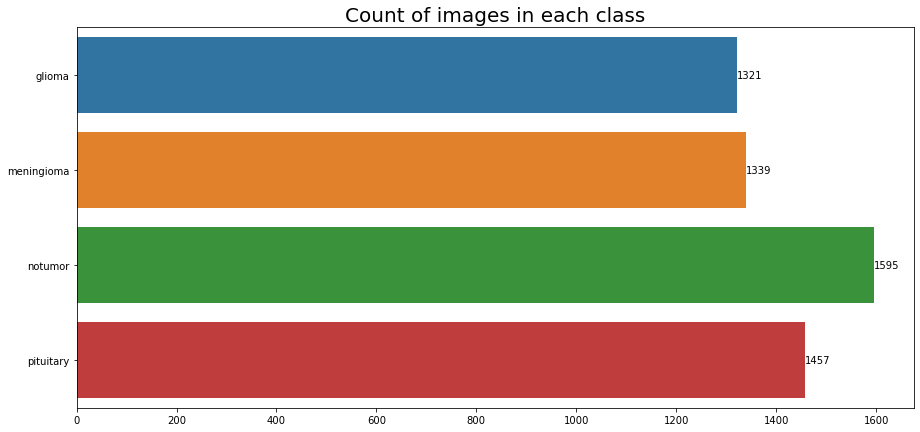

In [10]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

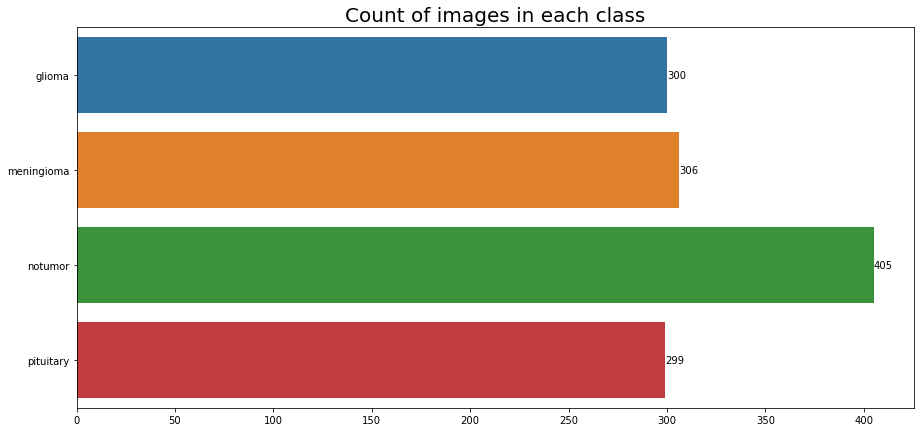

In [11]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df , y=ts_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [12]:
valid_df, ts_df = train_test_split(ts_df, train_size=.5, random_state=20)

In [13]:
valid_df

,Class Path,Class
464,Testing\meningioma\Te-me_0164.jpg,meningioma
987,Testing\notumor\Te-no_0381.jpg,notumor
565,Testing\meningioma\Te-me_0265.jpg,meningioma
503,Testing\meningioma\Te-me_0203.jpg,meningioma
502,Testing\meningioma\Te-me_0202.jpg,meningioma
...,...,...
1242,Testing\pituitary\Te-pi_0232.jpg,pituitary
924,Testing\notumor\Te-no_0318.jpg,notumor
1247,Testing\pituitary\Te-pi_0237.jpg,pituitary
271,Testing\glioma\Te-gl_0271.jpg,glioma


## Data augmentation and setting training image, validation images and testing image

### Data augmentation using Augmentor

#### Initialising a pipeline

In [14]:
import Augmentor

path_to_data = 'Training'

# create a pipeline
p = Augmentor.Pipeline(path_to_data)

Initialised with 5712 image(s) found.
Output directory set to Training\output.

#### Adding operations to a pipeline

In [15]:
# Add some operations to an existing pipeline.

# Add augmentation operations
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.flip_left_right(probability=0.5)
p.zoom_random(probability=0.5, percentage_area=0.8)
p.flip_top_bottom(probability=0.3)


#### Executing a pipeline

In [16]:
p.set_save_format("PNG")
p.sample(4000)

Processing <PIL.Image.Image image mode=RGB size=442x454 at 0x1C575ACB280>: 100%|█| 4000/4000 [00:44<00:00, 89.40 Sample


### Generating data frame for augmented_data

In [17]:
augmented_df = train_df('Training/output')

In [18]:
augmented_df

,Class Path,Class
0,Training/output\glioma\glioma_original_Tr-glTr...,glioma
1,Training/output\glioma\glioma_original_Tr-glTr...,glioma
2,Training/output\glioma\glioma_original_Tr-glTr...,glioma
3,Training/output\glioma\glioma_original_Tr-glTr...,glioma
4,Training/output\glioma\glioma_original_Tr-gl_0...,glioma
...,...,...
3995,Training/output\pituitary\pituitary_original_T...,pituitary
3996,Training/output\pituitary\pituitary_original_T...,pituitary
3997,Training/output\pituitary\pituitary_original_T...,pituitary
3998,Training/output\pituitary\pituitary_original_T...,pituitary


### Now combining original trainging data frame and augmented dataframe

In [19]:
# combine tr_df and augmented_df into a single dataframe
combined_df = pd.concat([tr_df,augmented_df], ignore_index=True)

# shuffle the combined dataframe 
# Shuffling helps introduce randomness into the order of your data,
#preventing the model from learning patterns based on the order of the examples.
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

In [20]:
combined_df

,Class Path,Class
0,Training/output\meningioma\meningioma_original...,meningioma
1,Training/output\notumor\notumor_original_Tr-no...,notumor
2,Training\meningioma\Tr-me_0205.jpg,meningioma
3,Training/output\notumor\notumor_original_Tr-no...,notumor
4,Training\notumor\Tr-no_0735.jpg,notumor
...,...,...
9707,Training/output\glioma\glioma_original_Tr-gl_0...,glioma
9708,Training\meningioma\Tr-me_0287.jpg,meningioma
9709,Training\notumor\Tr-no_1456.jpg,notumor
9710,Training/output\glioma\glioma_original_Tr-gl_1...,glioma


## Counting data after data augmentation

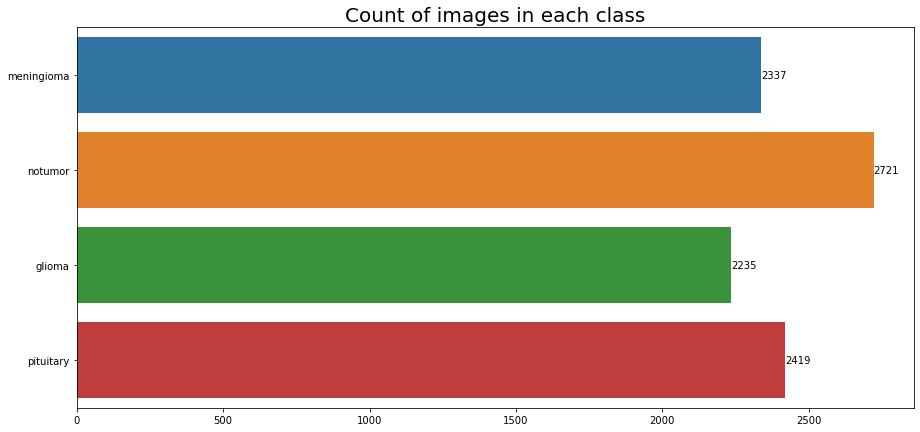

In [21]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=combined_df , y=combined_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [22]:
batch_size = 16
img_size = (299, 299)

tr_gen = ImageDataGenerator(brightness_range=(0.8, 1.2))

gen = ImageDataGenerator()

tr_gen = tr_gen.flow_from_dataframe(combined_df, 
                                         x_col='Class Path',
                                         y_col='Class',
                                         batch_size=batch_size,
                                         target_size=img_size)

valid_gen = gen.flow_from_dataframe(valid_df, 
                                    x_col='Class Path',
                                    y_col='Class',
                                    batch_size=batch_size,
                                    target_size=img_size)

ts_gen = gen.flow_from_dataframe(ts_df, 
                                 x_col='Class Path',
                                 y_col='Class',
                                 batch_size=batch_size,
                                 target_size=img_size,
                                 shuffle=False)

Found 9712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


## Visualization of Images

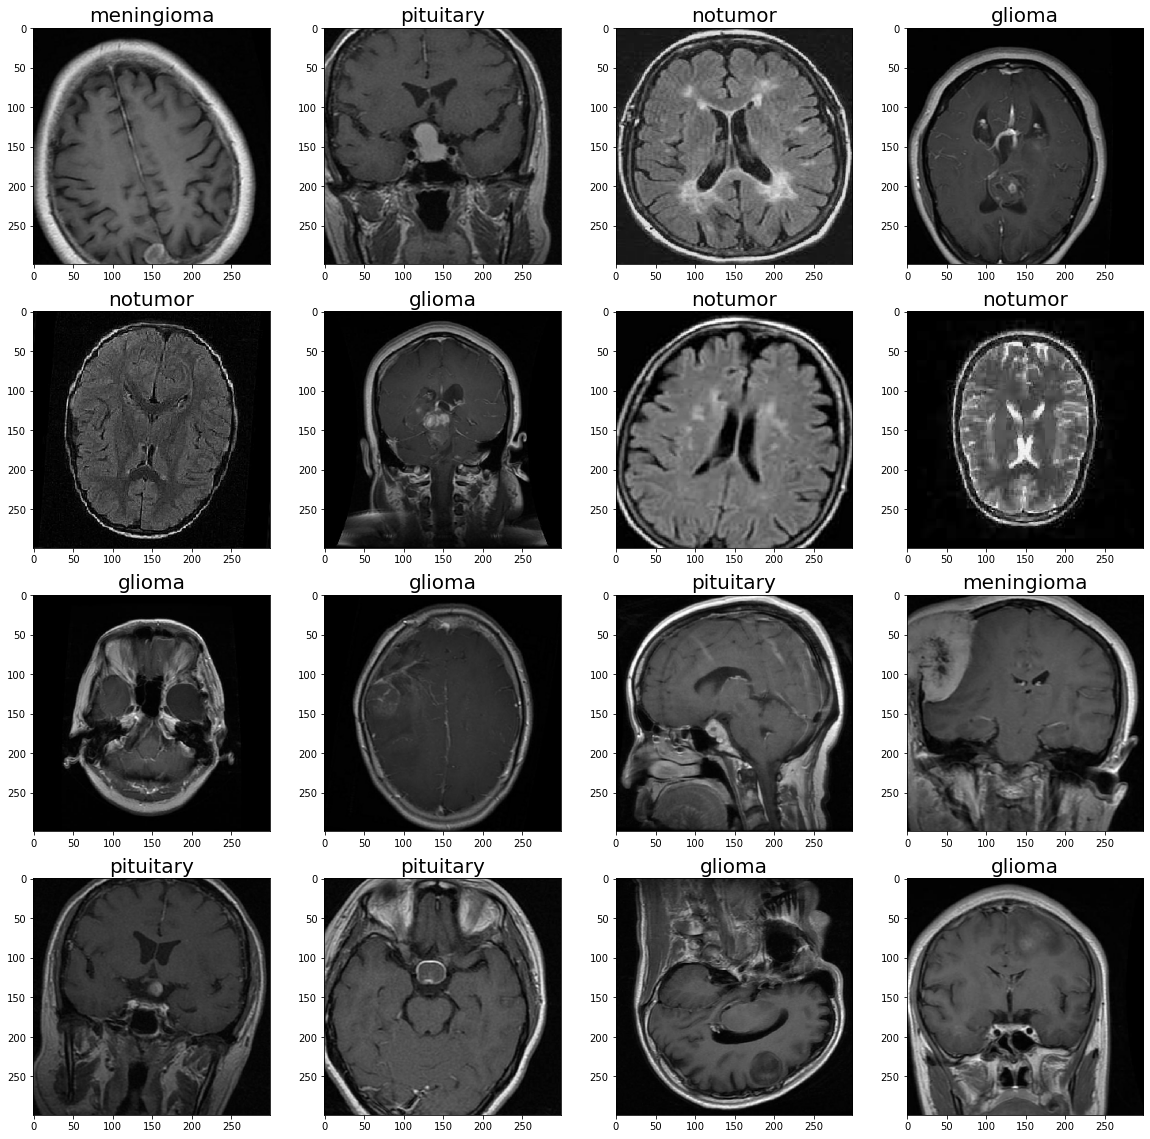

In [23]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='k', fontsize=20)
plt.show()

## Building a model

We are using InceptionV3 architecture to train our model along with attention mechanism

In [24]:
img_shape=(299,299,3)
base_model = tf.keras.applications.InceptionV3(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model = Sequential([
    base_model,
    Dropout(rate= 0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
    Dropout(rate= 0.25),
    Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 22082084 (84.24 MB)
Trainable params: 22

In [25]:
# img_shape = (299, 299, 3)

# base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",
#                                             input_shape=img_shape, pooling='max')

# # Freeze base model layers:
# for layer in base_model.layers:
#     layer.trainable = False

# model = Sequential([
#     base_model,
#     Dropout(rate=0.3),  # Increased dropout rate
#     Dense(128, activation='relu', kernel_regularizer=l2(0.02)),  # Reduced neurons, higher L2
#     Dropout(rate=0.25),  # Increased dropout rate
#     Dense(128, activation='relu', kernel_regularizer=l2(0.02)),  # Reduced neurons, higher L2
#     Dense(4, activation='softmax')
# ])

# model.compile(Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy',
#                        Precision(),
#                        Recall()])

# model.summary()


## Model Training

Model is trained using the trained config declared before.

In [26]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# hist = model.fit(tr_gen,
#                  epochs=10,
#                  validation_data=valid_gen,
#                  callbacks=[early_stopping],
#                  shuffle= False)

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(tr_gen,
    epochs=15,
    validation_data=valid_gen,
    callbacks=[early_stopping],
    shuffle=True)


Epoch 1/15


607/607 [==============================] - 1726s 3s/step - loss: 5.4082 - accuracy: 0.8626 - precision: 0.8895 - recall: 0.8356 - val_loss: 3.6467 - val_accuracy: 0.9557 - val_precision: 0.9657 - val_recall: 0.9466
Epoch 2/15
607/607 [==============================] - 1707s 3s/step - loss: 2.6683 - accuracy: 0.9561 - precision: 0.9627 - recall: 0.9503 - val_loss: 1.7797 - val_accuracy: 0.9802 - val_precision: 0.9801 - val_recall: 0.9756
Epoch 3/15
607/607 [==============================] - 1718s 3s/step - loss: 1.2992 - accuracy: 0.9688 - precision: 0.9728 - recall: 0.9650 - val_loss: 1.1133 - val_accuracy: 0.8992 - val_precision: 0.9095 - val_recall: 0.8901
Epoch 4/15
607/607 [==============================] - 1983s 3s/step - loss: 0.6085 - accuracy: 0.9783 - precision: 0.9809 - recall: 0.9753 - val_loss: 0.4269 - val_accuracy: 0.9771 - val_precision: 0.9785 - val_recall: 0.9725
Epoch 5/15
607/607 [==============================] - 1847s 3s/step - loss: 0.3198 - accuracy:

In [28]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

## Visualizing performance

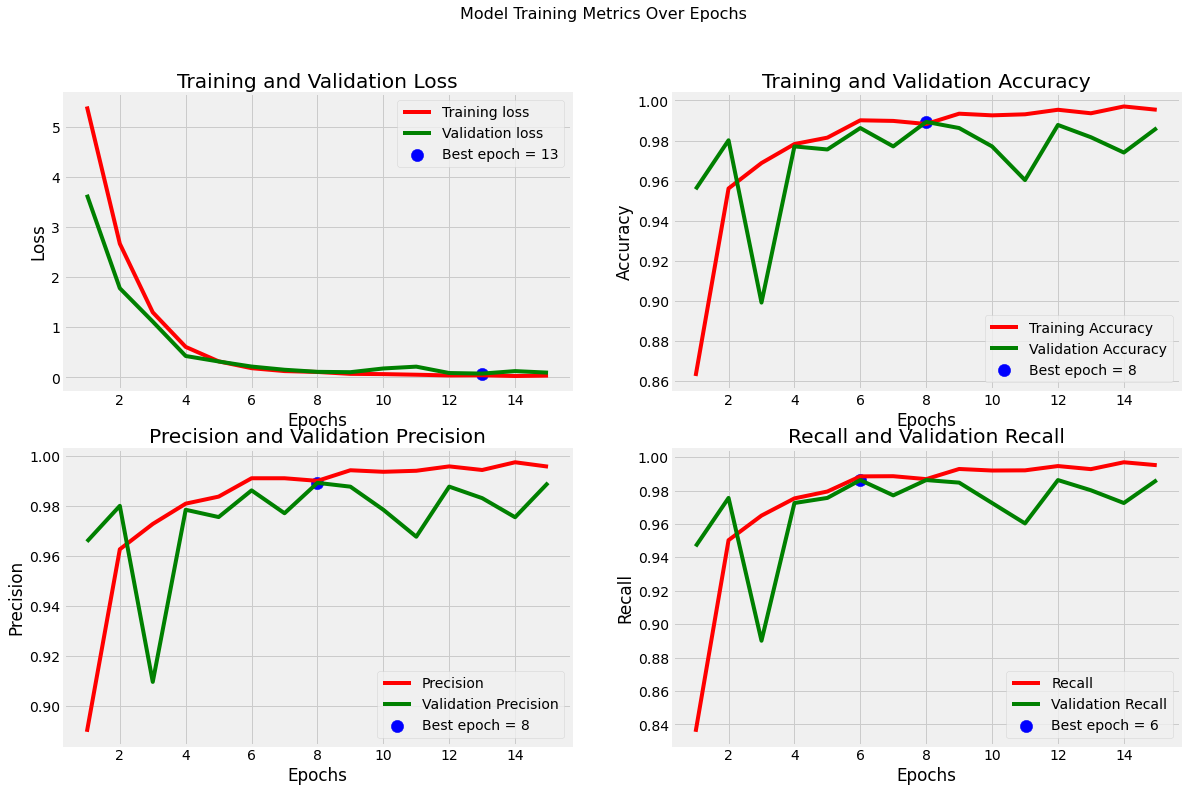

In [29]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()


In [30]:
train_score = model.evaluate(tr_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(ts_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 34s 836ms/step - loss: 0.0628 - accuracy: 0.9878 - precision: 0.9908 - recall: 0.9878
Train Loss:  0.023092566058039665
Train Accuracy:  0.9981465935707092
--------------------
Validation Loss:  0.09482061117887497
Validation Accuracy:  0.9862595200538635
--------------------
Test Loss:  0.06282863020896912
Test Accuracy:  0.9877862334251404


In [31]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 38s 878ms/step


### Confusin Matrix

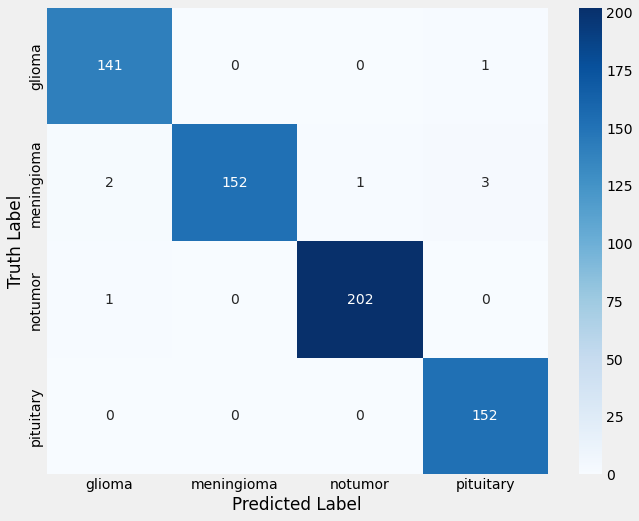

In [32]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

### Classification Report

In [33]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       142
           1       1.00      0.96      0.98       158
           2       1.00      1.00      1.00       203
           3       0.97      1.00      0.99       152

    accuracy                           0.99       655
   macro avg       0.99      0.99      0.99       655
weighted avg       0.99      0.99      0.99       655



## Saving a model

In [34]:
model.save("brain_tumor_model(inceptionV3)second.h5")

## Predicting some images using our model

In [35]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 2s 2s/step


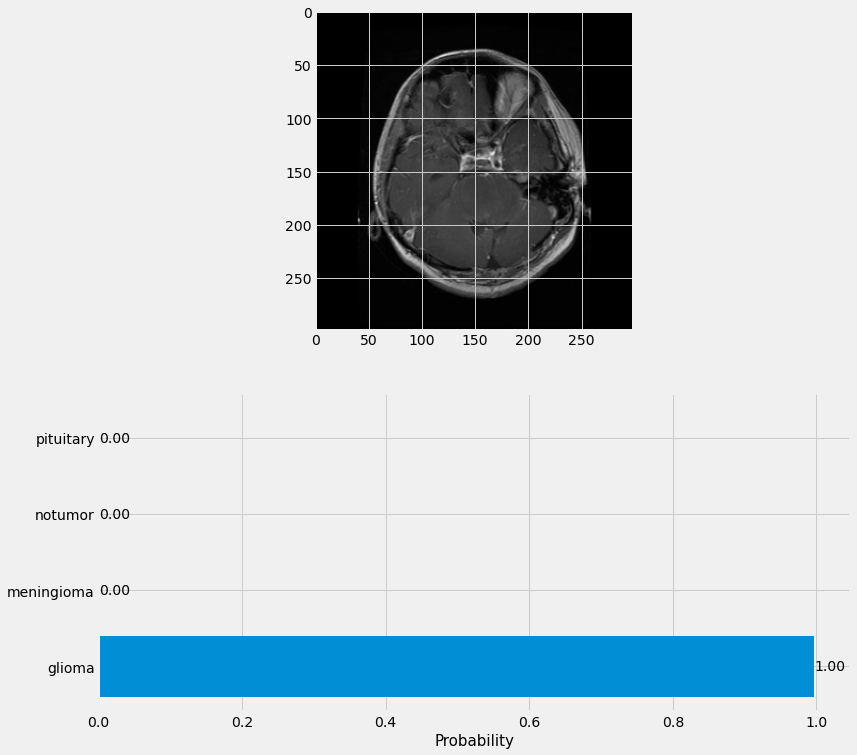

In [36]:
predict('Testing/glioma/Te-gl_0010.jpg')

1/1 [==============================] - 0s 83ms/step


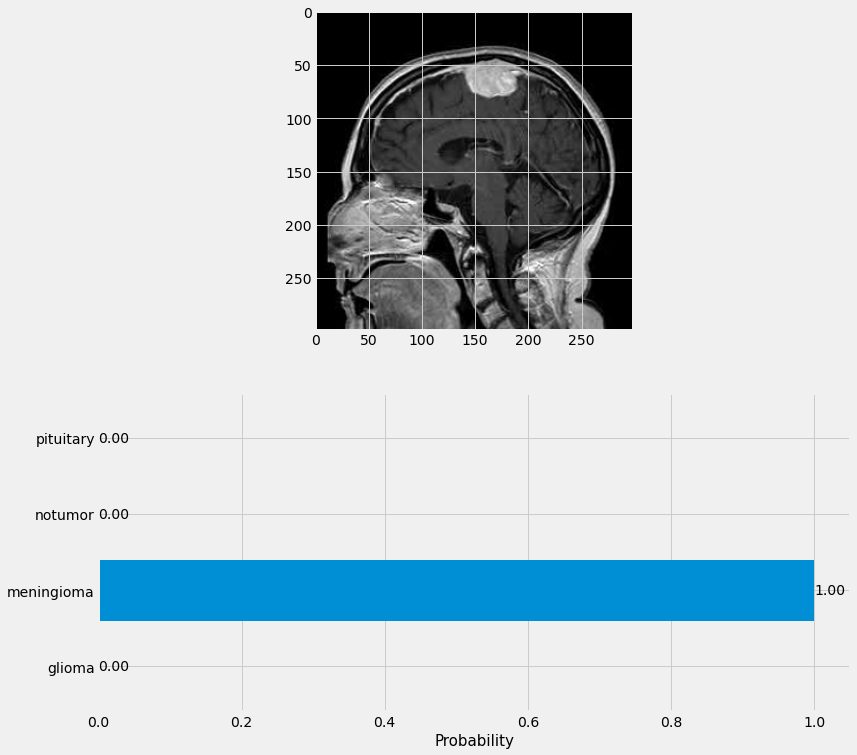

In [37]:
predict('Testing/meningioma/Te-me_0044.jpg')

1/1 [==============================] - 0s 90ms/step


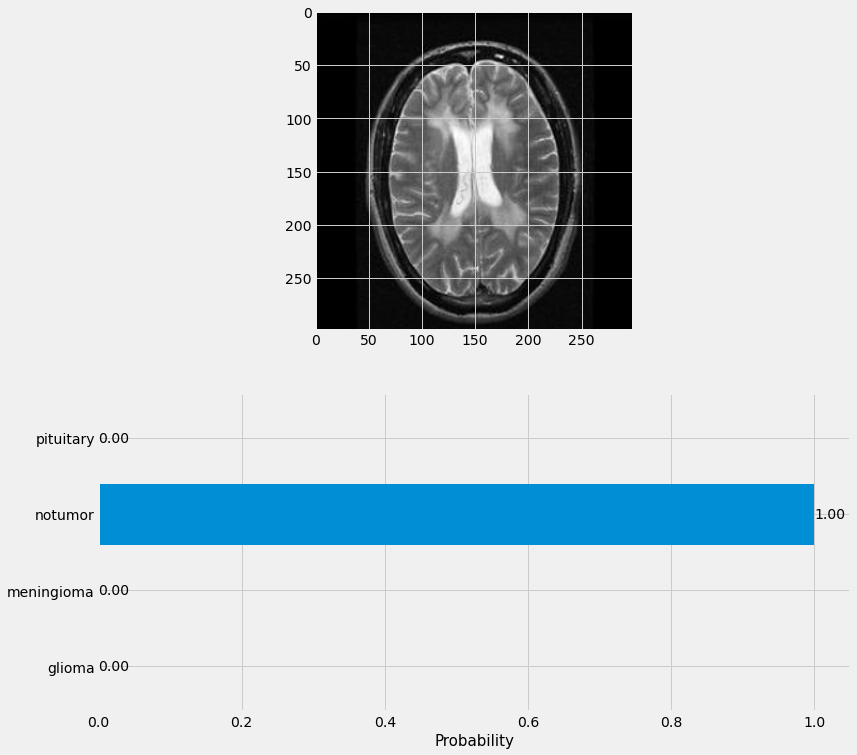

In [38]:
predict('Testing/notumor/Te-no_0032.jpg')

1/1 [==============================] - 0s 80ms/step


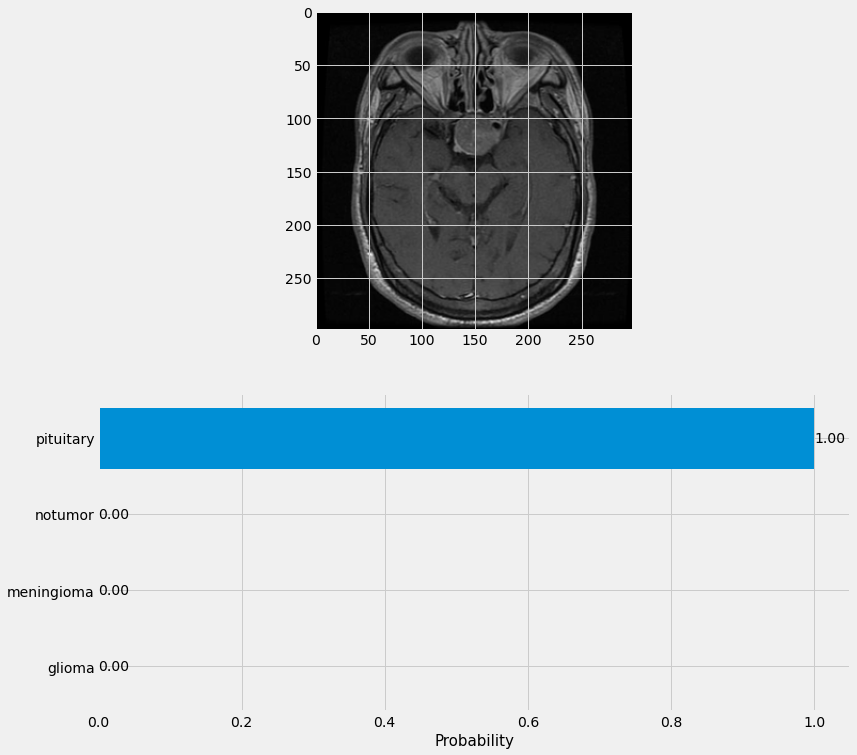

In [39]:
predict('Testing/pituitary/Te-pi_0052.jpg')

1/1 [==============================] - 0s 93ms/step


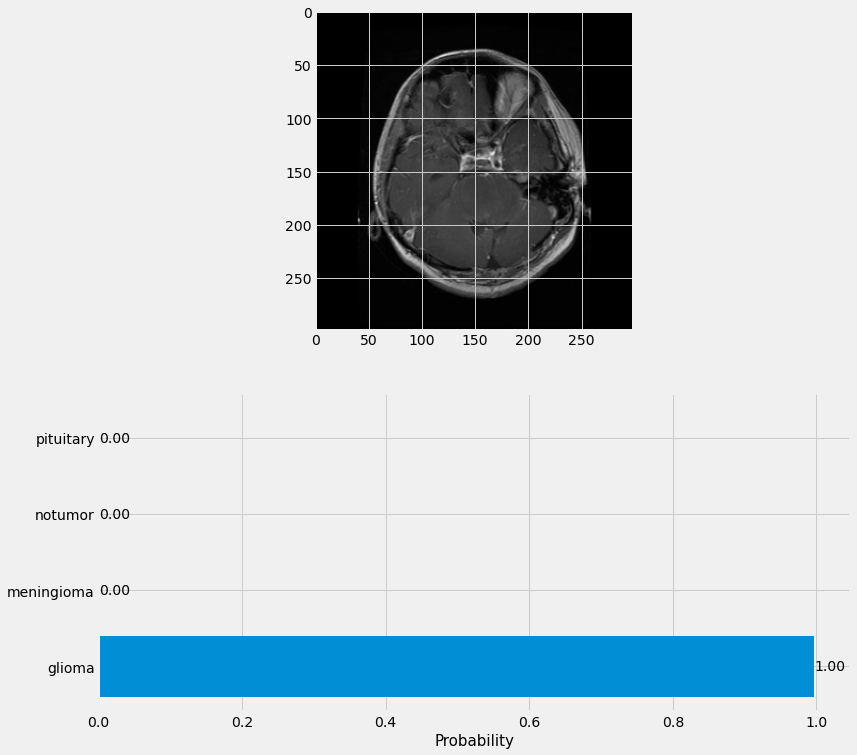

In [40]:
predict('Testing/glioma/Te-gl_0010.jpg')

In [1]:
predict('Testing/meningioma/Te-me_0302.jpg')

NameError: name 'predict' is not defined

In [ ]:
predict('Testing/notumor/Te-no0211.jpg')

In [ ]:
predict('Testing/pituitary/Te-pi_0298.jpg')